In [13]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ssvep_analyzer import SsvepAnalyzer

from scipy.signal import cwt, morlet2

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [14]:
def read_file(file_path):
    df = pd.read_csv(file_path, skiprows=10, header=None)
    with open(file_path, 'r') as file:
        content = file.read()
    match = re.search(r'Severity:\s*(\d+(\.\d+)?)', content)
    severity = float(match.group(1))
    eeg_data = df.to_numpy()[:, 1:9].astype(float)
    marker = df.to_numpy()[:, -1].flatten()
    return eeg_data, severity

def preprocess_data(eeg_data):
    analyzer = SsvepAnalyzer(sampling_rate=250, stimulus_frequency=16.5)
    eeg_data = analyzer.filter_extreme_values(eeg_data)
    eeg_data = analyzer.apply_linear_detrending(eeg_data)
    eeg_data = analyzer.apply_lowpass_filter(eeg_data)
    eeg_data = analyzer.apply_highpass_filter(eeg_data)
    eeg_data = analyzer.apply_notch_filter(eeg_data)
    reduced_eeg_data, _ = analyzer.compute_reduced_signal(eeg_data)
    return reduced_eeg_data

def build_dataset(directory_list):
    X = []
    y = []
    for directory in directory_list:
        for file in os.listdir('../Data/' + directory):
            file_path = '../Data/' + directory + '/' + file
            eeg_data, severity = read_file(file_path)
            reduced_eeg_data = preprocess_data(eeg_data)
            X.append(reduced_eeg_data)
            y.append(1 if severity > 0 else 0)

    # Pad with zeros to make all samples the same length
    max_length = max([len(reduced_eeg_data) for reduced_eeg_data in X])
    for i, reduced_eeg_data in enumerate(X):
        X[i] = np.concatenate((reduced_eeg_data, np.zeros(max_length - len(reduced_eeg_data))))
    return np.array(X), np.array(y)

directory_list = ['2024-01-12']

X, y = build_dataset(directory_list)

In [15]:
class WaveletTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, w=50, n_samples=100, sampling_rate=250, frequency=16.5):
        self.w = w
        self.n_samples = n_samples
        self.sampling_rate = sampling_rate
        self.frequency = frequency

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        width = self.w * self.sampling_rate / (2 * np.pi * self.frequency)
        cwt_matrix = np.apply_along_axis(lambda x: np.abs(cwt(x, morlet2, widths=[width], w=self.w, dtype='complex128')).flatten(), axis=1, arr=X)
        idx_mask = cwt_matrix.shape[1] // self.n_samples * np.arange(self.n_samples)
        cwt_matrix = cwt_matrix[:, idx_mask]
        return cwt_matrix

wavelet_transformer = WaveletTransformer()


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

pipeline = Pipeline([
    ('wavelet_transformer', wavelet_transformer),
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svm', SVC(probability=True))
])

grid = {
    'wavelet_transformer__w': [50],
    'wavelet_transformer__n_samples': [100],
    'pca__n_components': [4],
    'svm__C': [1],
    'svm__kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(pipeline, grid, cv=4, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best Params:', grid_search.best_params_)

y_pred = grid_search.predict(X_test)

print(f'Accuracy: {grid_search.score(X_test, y_test):.2f}')

Best Params: {'pca__n_components': 4, 'svm__C': 1, 'svm__kernel': 'linear', 'wavelet_transformer__n_samples': 100, 'wavelet_transformer__w': 50}
Accuracy: 0.87


AUC ROC: 0.95


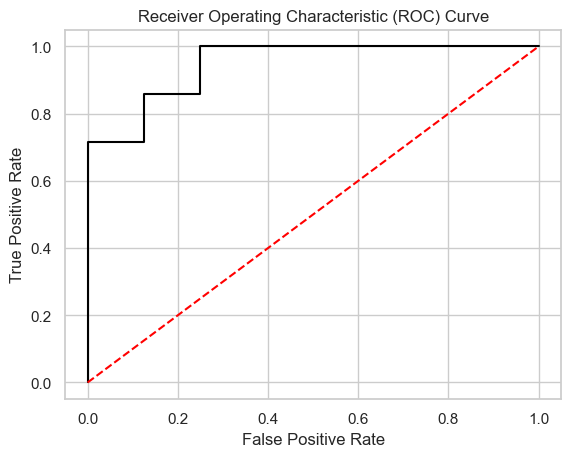

In [22]:
y_pred_proba = grid_search.predict_proba(X_test)
auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f'AUC ROC: {auc_roc:.2f}')


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

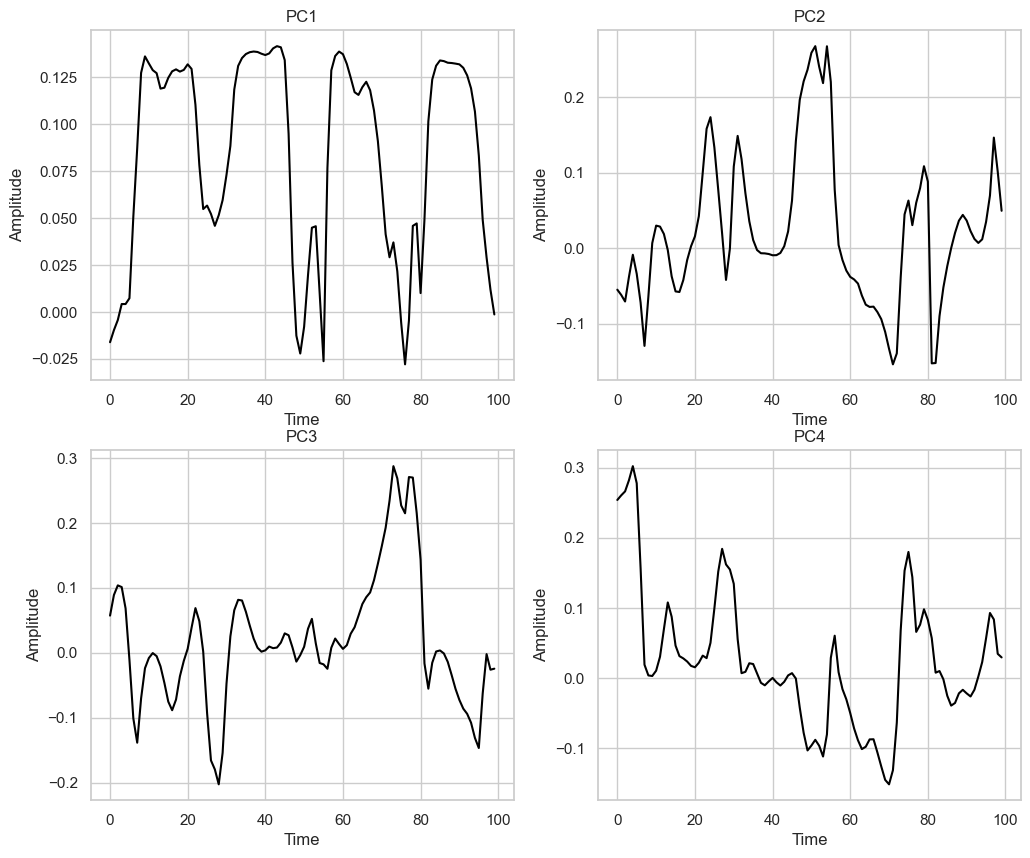

In [18]:
pca = grid_search.best_estimator_.named_steps['pca']

num_plots = len(pca.components_)
num_rows = (num_plots + 1) // 2 
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 5 * num_rows))
for idx, pc in enumerate(pca.components_):
    row = idx // 2
    col = idx % 2
    axes[row, col].plot(pc, color='black')
    axes[row, col].set_xlabel('Time')
    axes[row, col].set_ylabel('Amplitude')
    axes[row, col].set_title('PC' + str(idx + 1))
plt.show()

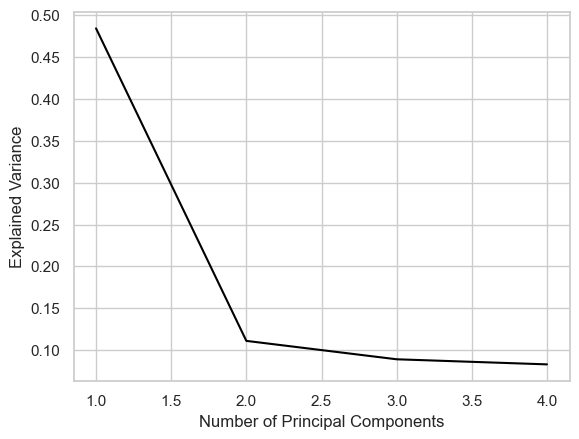

In [19]:
explained_variance = grid_search.best_estimator_.named_steps['pca'].explained_variance_ratio_
num_components = len(explained_variance)
plt.plot(range(1, num_components + 1), explained_variance, color='black')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.show()

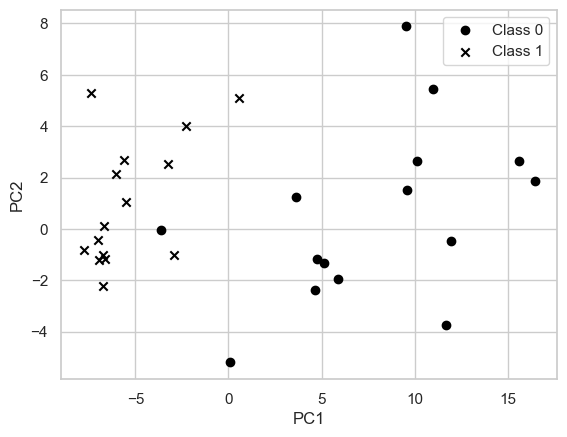

In [20]:
X_pca = grid_search.best_estimator_.named_steps['wavelet_transformer'].transform(X)
X_pca = grid_search.best_estimator_.named_steps['scaler'].transform(X_pca)
X_pca = grid_search.best_estimator_.named_steps['pca'].transform(X_pca)

markers = ['o', 'x']
for i, marker in enumerate(markers):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], marker=marker, label=f'Class {i}', color='black')

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()